In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openml

plt.style.use('ggplot')

#random_state
rs = 321

# Trabalho de Aprendizagem de Máquina I (PES Embraer)
Alunos: Caio Costa e Jonas Rodrigues

**Do Classroom:**

Seguem algumas instruções para realizar os experimentos:

- selecionar um banco de dados do OpenML (https://www.openml.org/)
    - o banco de dados de classificação deve ter: > 3 classes, >10 atributos e >1000 instâncias
    - cada dupla deve informar qual banco de dados usará com antecedência
- 10-fold cross-validation
- avaliar máquinas de aprendizagem: kNN, DT, MLP, NB, SVM, … 
- métricas (area under the ROC curve, f1-score, accuracy, matriz de confusão média)
- para ajustar os parâmetros das máquinas de aprendizagem usar grid-search ou escolher os parâmetros e justificar

O relatório final deve conter pelo menos as seguintes informações:
1. Introdução
2. Algoritmos de Aprendizagem de Máquina
3. Experimentos  
    3.1. Banco de dados  
    3.2. Métricas  
    3.3. Resultados   
4. Conclusões
5. Referências

In [2]:
data = openml\
        .datasets\
        .get_dataset(46, download_data=True, download_qualities=True, download_features_meta_data=True)

df = data.get_data()[0]

Could not download file from http://openml1.win.tue.nl/dataset46/dataset_46.pq: Bucket does not exist or is private.
Failed to download parquet, fallback on ARFF.


In [3]:
data

OpenML Dataset
Name..........: splice
Version.......: 1
Format........: ARFF
Upload Date...: 2014-04-06 23:22:49
Licence.......: Public
Download URL..: https://api.openml.org/data/v1/download/46/splice.arff
OpenML URL....: https://www.openml.org/d/46
# of features.: 61
# of instances: 3190

In [4]:
df.head()

,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,...,attribute_52,attribute_53,attribute_54,attribute_55,attribute_56,attribute_57,attribute_58,attribute_59,attribute_60,Class
0,C,C,A,G,C,T,G,C,A,T,...,G,C,C,A,G,T,C,T,G,EI
1,A,G,A,C,C,C,G,C,C,G,...,T,G,C,C,C,C,C,G,C,EI
2,G,A,G,G,T,G,A,A,G,G,...,A,C,G,G,G,G,A,T,G,EI
3,G,G,G,C,T,G,C,G,T,T,...,G,T,T,T,T,C,C,C,C,EI
4,G,C,T,C,A,G,C,C,C,C,...,C,T,T,G,A,C,C,C,T,EI


In [5]:
#contagem das bases
cols = df.iloc[:,:-1]
cols.melt()['value'].value_counts()

value
C    50300
G    50245
T    46308
A    44487
N       56
D        2
R        1
S        1
Name: count, dtype: int64

In [6]:
#verificação de quantas instâncias possuem as bases ambíguas (N, D, R, S)

#instâncias que contém N, D, R ou S entre as features
idx_ndrs = df.iloc[:,:-1]\
             .isin(["N", "D", "R", "S"])\
             .any(axis=1) 

print(f"Existem {len(df[idx_ndrs])} linhas com bases ambíguas (N, D, R ou S).")

Existem 15 linhas com bases ambíguas (N, D, R ou S).


# Avaliação das classes target

In [7]:
df['Class'].value_counts()

Class
N     1655
IE     768
EI     767
Name: count, dtype: int64

<Axes: >

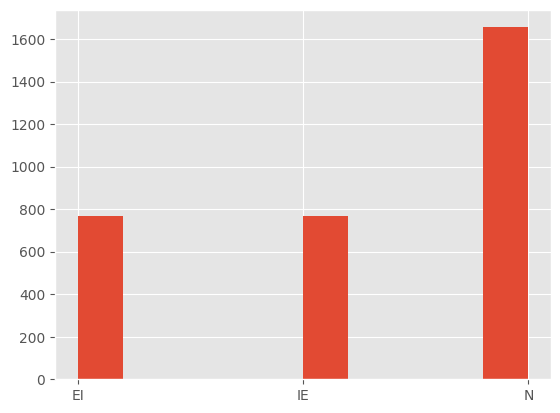

In [8]:
df['Class'].hist()

# Preparo do dataset

In [9]:
#remoção das instâncias com bases ambíguas

df = df[~idx_ndrs]

In [10]:
#converter colunas para categorical
for col in df.columns:
    df[col] = df[col].cat.remove_unused_categories()

# Encoding das features e targets

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

F = df.columns[:-1].to_list()
T = df.columns[-1]

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), F),
    ('oe', OrdinalEncoder(), [T]) #para este caso, LabelEncoder == OrdinalEncoder
])

In [12]:
encoded = ct.fit_transform(df).toarray()

In [13]:
encoded

array([[0., 1., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 2.],
       [1., 0., 0., ..., 0., 0., 2.],
       [1., 0., 0., ..., 0., 1., 2.]])

# Divisão treino-teste
80% treino, 20% teste

In [14]:
from sklearn.model_selection import train_test_split

X = encoded[:, :-1]
y = encoded[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

print(f'X shape: ')
print(f'    Train = {X_train.shape}')
print(f'    Train = {X_test.shape}')
print(f'y shape: ')
print(f'    Train = {y_train.shape}')
print(f'    Test = {y_test.shape}')

X shape: 
    Train = (2540, 240)
    Train = (635, 240)
y shape: 
    Train = (2540,)
    Test = (635,)


Como vimos na análise anterior, nossa base de dados não é demasiadamente desbalanceada. Então optamos por não estratificar nesse caso.

In [15]:
pd.Series(y_train).value_counts(normalize=True)

2.0    0.516929
1.0    0.243307
0.0    0.239764
Name: proportion, dtype: float64

In [16]:
pd.Series(y_test).value_counts(normalize=True)

2.0    0.527559
0.0    0.240945
1.0    0.231496
Name: proportion, dtype: float64

Isso pode ser visto de maneira mais objetiva pelas células acima. É claro que temos uma proporção maior da classe do tipo 2, mas não de forma que acreditamos que seja consideravelmente superior às outras, o que poderia ser um indício de performance ruim dos algoritmos de aprendizado se simplesmente alimentássemos a eles os dados sem demais considerações.

# Classificadores e parâmetros para busca


Nesta seção e nas seguintes, exploraremos os seguintes algoritmos de aprendizado e seus hiperparâmetris:

- kNearest Neighbors (KNN);
- Decision Trees (DT);
- Multi-Layer Perceptron (MLP);
- Naive-Bayes (NB); 
- Support Vector Machines (SVM).

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve

In [18]:
estimators = {'knn': KNeighborsClassifier(), 
              'dt': DecisionTreeClassifier(),
              'mlp': MLPClassifier(),
              'nb': BernoulliNB(),
              'svm': SVC(probability=True)}

In [19]:
#listagem de hiperparâmetros

for a, b in estimators.items():
    print("Parâmetros padrões para {}: \n{}\n".format(b, b.get_params()))

Parâmetros padrões para KNeighborsClassifier(): 
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}

Parâmetros padrões para DecisionTreeClassifier(): 
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

Parâmetros padrões para MLPClassifier(): 
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation

In [20]:
#parâmetros para busca

param_grid = {
    
    'knn': [{
        'n_neighbors': [5, 7, 9, 11, 13, 15, 17, 19, 20, 30, 40, 50, 60, 70],
        'weights': ['uniform', 'distance'],
        'p': [1,2]
    },
    {
        'metric': ['hamming'],
        'weights': ['uniform', 'distance'],
        'n_neighbors': [5, 7, 9, 11, 13, 15, 17, 19, 20, 30, 40, 50, 60, 70]
    }],
    
    'dt': {
        'criterion': ["gini", "entropy", 'log_loss'],
        'splitter': ['best', 'random'],
        'min_samples_leaf': [1, 2, 3]
    },
    
    'mlp': {
        {
            'hidden_layer_sizes': [[2], [4], [8], [2, 4, 2], [2, 4, 8, 4, 2]],
            'activation': ['logistic', 'tanh', 'relu'],
            'solver': ['lbfgs'],
            'learning_rate_init': [1e-4, 1e-3, 1e-2, 1e-1],
            'batch_size': [32, 64, 128, 256]
        },
        {
            'hidden_layer_sizes': [[2], [4], [8], [2, 4, 2], [2, 4, 8, 4, 2]],
            'activation': ['logistic', 'tanh', 'relu'],
            'solver': ['adam'],
            'learning_rate_init': [1e-4, 1e-3, 1e-2, 1e-1],
            'batch_size': [32, 64, 128, 256],
            'max_iter': [10, 50, 100, 200, 500]
        }
    },
    
    'nb': {
        'alpha': [0.001, 0.01, 0.1, 1, 2, 10],
        'fit_prior': [True, False]
    },

    'svm': [{
        'C': [1, 2, 5, 10],
        'kernel': ['linear', 'rbf']
        },
        {
        'C': [1, 2, 5, 10],
        'kernel': ['poly'],
        'degree': [2, 3]
    }]

}


# 10-fold stratified cross-validation

In [21]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=rs)

# Baseline

In [22]:
from sklearn.dummy import DummyClassifier

dummy_clf_1 = DummyClassifier(strategy="most_frequent").fit(X_train, y_train)
y_d1 = dummy_clf_1.predict(X_test)

dummy_clf_2 = DummyClassifier(strategy="stratified").fit(X_train, y_train)
y_d2 = dummy_clf_2.predict(X_test)

In [23]:
print(f"Baseline de acurácia (prever o mais frequente) = {accuracy_score(y_d1, y_test)}")
print(f"Baseline de acurácia (prever aleatoriamente na mesma proporção) = {accuracy_score(y_d2, y_test)}")

Baseline de acurácia (prever o mais frequente) = 0.5275590551181102
Baseline de acurácia (prever aleatoriamente na mesma proporção) = 0.3826771653543307


In [24]:
print(f"Baseline de f1_score (prever o mais frequente) = {f1_score(y_d1, y_test, average='macro')}")
print(f"Baseline de f1_score (prever aleatoriamente na mesma proporção) = {f1_score(y_d2, y_test, average='macro')}")

Baseline de f1_score (prever o mais frequente) = 0.23024054982817868
Baseline de f1_score (prever aleatoriamente na mesma proporção) = 0.3323284479576023


# Início tracking MLflow

In [25]:
import mlflow
import mlflow.sklearn

Rode o `mlflow ui`. Precisa apenas ser inicializado; depois disso, pode 

In [38]:
%%sh
mlflow ui

[2023-07-28 11:02:04 -0300] [47030] [INFO] Starting gunicorn 20.1.0
[2023-07-28 11:02:04 -0300] [47030] [INFO] Listening at: http://127.0.0.1:5000 (47030)
[2023-07-28 11:02:04 -0300] [47030] [INFO] Using worker: sync
[2023-07-28 11:02:04 -0300] [47031] [INFO] Booting worker with pid: 47031
[2023-07-28 11:02:04 -0300] [47032] [INFO] Booting worker with pid: 47032
[2023-07-28 11:02:04 -0300] [47033] [INFO] Booting worker with pid: 47033
[2023-07-28 11:02:04 -0300] [47034] [INFO] Booting worker with pid: 47034


In [39]:
mlflow.sklearn.autolog()

In [40]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [41]:
#função para gravar métricas de teste

def log_eval_metrics(actual, pred, pred_proba, prefix='test_'):
    
    f1 = f1_score(actual, pred, average='macro')
    acc = accuracy_score(actual, pred)
    roc_auc = roc_auc_score(actual, pred_proba, multi_class='ovr', average='macro') #'ovr' ou 'ovo'
    
    mlflow.log_metric(prefix + 'f1_score', f1)
    mlflow.log_metric(prefix + 'acc_score', acc)
    mlflow.log_metric(prefix + 'roc_auc_score', roc_auc)
    
    return f1, acc, roc_auc

# Grid Search CV

In [42]:
from sklearn.metrics import accuracy_score, make_scorer

metrics = {"AUC": make_scorer(roc_auc_score, multi_class='ovo', needs_proba=True),
           "Accuracy": make_scorer(accuracy_score),
           "F1-Score": make_scorer(f1_score, average='macro')}

In [43]:
from sklearn.model_selection import GridSearchCV

best_estimators = {}
cv_results_train = {}
results_test = {}

mlflow.end_run()

for (name, est), (_, params) in zip(estimators.items(), param_grid.items()):
    
    est_name = name
    est_est = est
    est_params = params
    
    mlflow.start_run()
    mlflow.set_tag('estimator', est_name)
    
    print(f"Executando {est_name}...")
    
    grid = GridSearchCV(estimator = est_est,
                        param_grid = est_params,
                        scoring = metrics,
                        cv = cv,
                        verbose=2,
                        n_jobs=-1,
                        refit="F1-Score")
    
    grid.fit(X_train, y_train)
    
    cv_results_train[est] = grid.cv_results_
    best_estimators[est] = grid.best_estimator_
    
    #predição
    y_pred = grid.predict(X_test)
    y_pred_proba = grid.predict_proba(X_test)
    
    results_test[est] = log_eval_metrics(y_test, y_pred, y_pred_proba)

    mlflow.end_run()

Executando knn...
Fitting 10 folds for each of 84 candidates, totalling 840 fits


[CV] END ...............n_neighbors=5, p=1, weights=distance; total time=   0.7s
[CV] END ................n_neighbors=5, p=1, weights=uniform; total time=   0.6s
[CV] END ...............n_neighbors=5, p=1, weights=distance; total time=   0.7s
[CV] END ................n_neighbors=5, p=1, weights=uniform; total time=   0.7s
[CV] END ................n_neighbors=5, p=1, weights=uniform; total time=   0.8s
[CV] END ................n_neighbors=5, p=1, weights=uniform; total time=   0.8s
[CV] END ................n_neighbors=5, p=1, weights=uniform; total time=   0.8s
[CV] END ................n_neighbors=5, p=1, weights=uniform; total time=   0.7s
[CV] END ................n_neighbors=5, p=1, weights=uniform; total time=   0.7s
[CV] END ................n_neighbors=5, p=1, weights=uniform; total time=   0.8s
[CV] END ................n_neighbors=5, p=1, weights=uniform; total time=   0.8s
[CV] END ................n_neighbors=5, p=1, weights=uniform; total time=   1.0s
[CV] END ...............n_ne

2023/07/28 11:04:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
2023/07/28 11:04:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/jonasrlg/.local/lib/python3.11/site-packages/mlflow/sklearn/utils.py:788: UserWarning: Top 5 child runs will be created based on ordering in rank_test_AUC column.  You can choose not to limit the number of child runs created by setting `max_tuning_runs=None`."
2023/07/28 11:04:35 INFO mlflow.sklearn.utils: Logging the 5 best runs, 79 runs will be omitted.


Executando dt...
Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV] END ..criterion=gini, min_samples_leaf=1, splitter=best; total time=   0.1s
[CV] END ..criterion=gini, min_samples_leaf=1, splitter=best; total time=   0.1s
[CV] END ..criterion=gini, min_samples_leaf=1, splitter=best; total time=   0.1s
[CV] END ..criterion=gini, min_samples_leaf=1, splitter=best; total time=   0.1s
[CV] END ..criterion=gini, min_samples_leaf=1, splitter=best; total time=   0.2s
[CV] END ..criterion=gini, min_samples_leaf=1, splitter=best; total time=   0.1s
[CV] END ..criterion=gini, min_samples_leaf=1, splitter=best; total time=   0.1s
[CV] END ..criterion=gini, min_samples_leaf=1, splitter=best; total time=   0.2s
[CV] END ..criterion=gini, min_samples_leaf=1, splitter=best; total time=   0.2s
[CV] END criterion=gini, min_samples_leaf=1, splitter=random; total time=   0.1s
[CV] END ..criterion=gini, min_samples_leaf=1, splitter=best; total time=   0.2s
[CV] END criterion=gini, min_

2023/07/28 11:04:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/jonasrlg/.local/lib/python3.11/site-packages/mlflow/sklearn/utils.py:788: UserWarning: Top 5 child runs will be created based on ordering in rank_test_AUC column.  You can choose not to limit the number of child runs created by setting `max_tuning_runs=None`."
2023/07/28 11:04:46 INFO mlflow.sklearn.utils: Logging the 5 best runs, 13 runs will be omitted.


Executando mlp...
Fitting 10 folds for each of 1200 candidates, totalling 12000 fits
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learni

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packag

[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-pa

[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   3.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   4.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   5.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   5.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   3.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   1.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   5.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  10.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  10.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  12.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  11.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   4.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   4.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  13.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   5.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   5.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   3.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   4.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   9.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   5.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   4.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   4.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   9.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  10.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  10.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   5.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   6.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   9.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   9.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  10.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   1.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   9.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   9.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  10.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   9.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   8.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   9.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   9.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   2.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   2.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   2.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   2.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   2.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   3.4s
[CV] END activation=l

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packag

[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packag

[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   3.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   2.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.4s[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   3.7s

[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, 

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-pa

[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   2.1s
[CV] END activation=logistic, ba

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   2.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   2.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   3.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   3.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   1.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   1.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   1.6s
[CV] END activation=logist

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   1.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   1.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   1.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   2.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   1.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   2.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   2.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   2.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   2.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   2.3s
[CV] END activation=logistic

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   1.2s
[CV] END activation=l

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packag

[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   1.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   2.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   2.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   1.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   3.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   2.7s
[CV] END activation

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   1.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   1.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   4.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   4.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   4.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   4.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   4.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   4.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   4.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   4.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   4.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-pack

[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   4.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packag

[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s

[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   7.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   1.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   9.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   1.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   7.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   8.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   9.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   8.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   9.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   9.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  10.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  10.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   4.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   4.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   5.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   5.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   5.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   5.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   5.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   4.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   5.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   5.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   8.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   1.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  10.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   1.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   9.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   8.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   8.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   8.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   9.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.3s[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   9.5s



/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   9.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   9.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   2.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   2.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   4.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   2.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   4.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   3.1s
[CV] END activation=l

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   4.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   4.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   3.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   4.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   3.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   3.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   3.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   3.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   3.5s
[CV] END activation=logi

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   4.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   1.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   2.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   2.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   1.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   2.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   1.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   1.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   1.1s
[CV] END activation=logistic,

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   2.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   1.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   2.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   1.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   1.0s
[CV] END activation=logi

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   1.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   2.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   1.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   2.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   2.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.7s
[CV] END activation

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   4.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   5.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   4.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   5.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   5.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   5.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   5.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   5.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packag

[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s



/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  10.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   8.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  11.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   1.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   9.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  10.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   8.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   9.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   9.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   9.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  10.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   4.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   5.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   4.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   4.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   4.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   5.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   4.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   4.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   5.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-pack

[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   4.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   8.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   8.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   7.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   6.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   6.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   8.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   8.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   3.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   9.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   9.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   3.4s[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   3.3s

[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   4.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  11.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   4.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   6.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   4.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   5.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   5.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   6.2s
[CV] END activation

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   6.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packag

[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   6.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   2.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   2.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   2.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   6.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   5.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   4.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   4.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   1.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   1.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   4.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   1.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   4.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   2.0s
[CV] END activation=logistic

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packag

[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   1.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; tota

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   1.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   3.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   1.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   1.3s
[CV] E

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-pa

[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   1.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   1.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   3.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   3.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   2.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   3.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   4.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   4.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   4.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   5.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   7.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-pack

[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.9s

[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  12.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  13.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  13.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  13.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  12.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  11.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  12.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  13.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  13.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  13.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   6.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   5.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   5.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   5.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   6.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   5.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   5.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   5.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   6.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   6.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packag

[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  11.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  11.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   3.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   3.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   3.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  10.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  11.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   3.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  12.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  12.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  11.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  12.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  12.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   4.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   3.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  13.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   3.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   3.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   4.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   4.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   6.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   2.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   6.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   4.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   4.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   5.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total 

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-pack

[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   6.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   5.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   6.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   3.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   2.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   4.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   4.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   2.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   3.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   8.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   3.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   3.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   3.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   3.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   3.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   3.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   3.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   1.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   3.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   3.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   1.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   4.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=  10.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; tot

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   3.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   3.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   1.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   4.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, m

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   1.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   3.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   3.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   6.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   6.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   1.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   4.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   5.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   6.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   4.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   1.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   4.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   4.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   4.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   4.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   5.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   5.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   4.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   2.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   2.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   3.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   7.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   8.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   7.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   8.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  10.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   3.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   1.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   1.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  10.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   1.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=  12.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   2.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   2.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   1.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   1.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   2.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   5.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   2.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   2.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   7.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  17.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   5.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   5.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  17.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   6.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   6.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   8.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   8.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   6.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   7.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   7.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  15.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   7.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=  12.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=  11.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   9.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=  13.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=  10.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=  14.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=  14.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=  16.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=  15.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  15.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=  16.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  12.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  17.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  14.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  16.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   5.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  19.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   6.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   8.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   7.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   7.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  15.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  20.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   7.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   5.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   5.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   6.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   8.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   8.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   8.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=  11.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  29.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  30.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=  13.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   6.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=  11.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=  14.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=  16.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=  12.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=  16.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.3s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   9.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=  13.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   1.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   1.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   2.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   8.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   1.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   1.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   2.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   1.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   1.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   8.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   1.2s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=  12.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   2.0s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=  15.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   1.8s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   2.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   1.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   4.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_ini

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   4.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packag

[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   3.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   4.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   5.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   6.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   1.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   5.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.6s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   5.4s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   9.7s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   5.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   4.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.9s
[CV] END activation=logistic, batch_size=32, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   8.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   4.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   5.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   4.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   5.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   5.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packag

[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s



/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  10.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   9.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   8.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   9.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   4.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  13.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  10.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   1.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  12.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  10.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  11.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  14.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   4.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   3.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   6.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   6.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   6.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   6.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   6.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   5.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   7.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   7.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   9.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   7.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  10.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   7.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  11.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  12.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  10.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   3.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   3.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   3.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  12.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  13.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  13.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   3.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   3.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   3.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   4.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   4.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   3.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   6.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   5.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   6.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   4.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   4.7s[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s

[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   6.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   5.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   3.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   4.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   1.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   1.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-pa

[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   7.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   6.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   5.4s[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.6s

[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   1.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   1.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   0.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   1.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   1.5s
[CV] END activation=logistic, ba

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   0.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   1.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   2.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   3.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   2.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   1.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   1.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   1.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logisti

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   2.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   3.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   1.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   1.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   1.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   2.8s
[CV] END activation=logi

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-pa

[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   3.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   5.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   1.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   1.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   5.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   4.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   5.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   4.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   4.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   5.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   5.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   7.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   7.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   7.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   1.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   9.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  12.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  11.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  15.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  10.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  14.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   4.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  12.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  14.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   4.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  13.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  13.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   3.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   5.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   4.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   6.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   6.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   5.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   6.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   7.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   7.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   8.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   9.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   8.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   3.5s[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  14.9s



/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   1.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  14.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   1.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  14.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   3.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   1.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  11.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  11.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   1.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  11.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   1.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  14.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  13.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   2.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   4.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   3.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   3.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   4.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   2.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   4.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   4.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   3.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   5.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   5.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   5.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   3.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-pa

[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   3.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   4.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   1.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   1.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   1.5s
[CV] END activation=logistic, 

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   5.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   1.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   6.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   2.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   0.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   1.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   1.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   1.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   1.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   1.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   1.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   0.7s
[CV] END activation=logistic, 

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packag

[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   0.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s[CV] END activation=log

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packag

[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   1.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   1.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   0.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   2.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   2.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[4], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   2.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   1.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-pa

[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   1.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   1.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   1.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   1.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   1.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   1.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   1.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   3.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   3.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   3.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   3.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   3.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   3.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   4.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   4.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   4.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   4.6s



/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packag

[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   5.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   1.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   1.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   8.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   1.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   7.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   7.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   6.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   1.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   6.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   1.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   7.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   7.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   1.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   1.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   8.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   8.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   2.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   3.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   3.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   4.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   3.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   3.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   4.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   4.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   4.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   4.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packag

[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   7.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   1.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   8.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   7.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   6.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   7.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   7.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   7.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   3.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  10.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  10.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  10.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   4.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   5.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   4.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   4.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   5.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   4.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   6.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   6.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   5.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   7.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   8.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   7.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   6.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   5.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   7.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   5.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   1.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   6.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   1.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   1.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   2.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=200, solver=adam; total time=  10.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   2.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   7.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   7.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   9.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   7.9s
[CV] END activation=logi

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.01, max_iter=200, solver=adam; total time=  10.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   2.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   1.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   2.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   2.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   2.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   5.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   2.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   4.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   3.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   4.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   1.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   1.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   4.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   1.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   4.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   2.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   1.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   1.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   4.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   1.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   4.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   1.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   6.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   4.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   4.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   4.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   4.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[8], learning_rate_init=0.1, max_iter=200, solver=adam; total time=  10.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   5.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   7.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   8.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   7.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   7.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   8.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   9.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   8.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   8.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   1.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   1.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   1.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   1.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  15.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  13.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  11.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   4.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  12.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  17.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   4.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  15.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   4.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  16.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  15.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  17.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   4.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  15.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   4.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   4.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   4.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   7.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   6.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   7.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   8.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   7.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   9.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   9.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   8.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   8.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=  10.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  10.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  13.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  13.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   3.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   4.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  14.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   4.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  19.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  13.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  19.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   3.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   4.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   3.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   4.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   4.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   4.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  17.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   4.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   5.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  17.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  17.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   6.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   8.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   5.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   8.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   8.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   7.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   5.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   8.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   8.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   7.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   9.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   4.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   1.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   8.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   1.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   1.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   6.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   1.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   6.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   2.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   3.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   3.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   8.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   8.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   4.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   4.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   3.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   4.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   8.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   3.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   4.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   3.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=  11.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   2.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   2.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   3.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   2.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; tota

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   6.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   6.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   5.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s



/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   1.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   2.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   5.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   4.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   1.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   5.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   1.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   1.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   5.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=  10.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   1.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   6.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   7.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   1.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   6.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   8.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   5.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   5.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   5.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   5.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   5.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   5.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   5.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   1.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   2.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   7.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   7.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   7.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   8.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=  10.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   7.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=  10.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   8.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=  11.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=  11.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   1.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   1.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   1.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   1.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   7.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   9.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   8.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  12.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  14.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   5.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   5.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   6.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   4.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   5.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   5.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   5.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  14.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  17.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   7.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   9.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   7.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=  11.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=  11.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=  10.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=  11.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   9.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=  11.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=  11.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.2s



/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  12.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  17.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  14.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   5.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   6.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   5.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  12.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   4.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  17.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  20.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  16.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   4.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   4.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   2.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  17.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   5.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  21.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   4.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  18.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   6.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   6.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   6.9s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   5.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   4.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   6.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   8.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   7.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   6.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=  11.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-pack

[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   9.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   9.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   1.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   2.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   1.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   1.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   1.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   1.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   7.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   2.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   2.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   9.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   2.3s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_i

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   3.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   2.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   2.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   5.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   3.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   3.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   2.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   3.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   2.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   2.8s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   4.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   4.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s

[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   3.2s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   2.3s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.8s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   1.0s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=  18.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   1.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   3.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   5.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   4.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   4.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.3s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.4s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.6s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   7.5s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   7.5s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=[2, 4, 8, 4, 2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   9.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   5.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   4.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   4.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.9s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   5.9s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.2s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   7.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   6.5s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   8.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.8s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   1.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  10.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  12.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  12.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=   9.6s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   1.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   4.3s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   4.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.6s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  13.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  13.3s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.0s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  12.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  12.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  14.4s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  14.3s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   4.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   5.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   6.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   5.8s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   7.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   7.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   6.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   7.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   7.9s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   7.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.3s

[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.3s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   8.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.0s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.8s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  10.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   9.7s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   3.4s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   3.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  15.0s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  11.2s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   3.9s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  11.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  13.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  13.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   3.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   4.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  16.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   5.9s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   5.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   6.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   6.3s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  16.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   6.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   5.3s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   8.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   6.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   5.4s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=100, solver=adam; total time=   5.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.3s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   1.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   1.5s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   7.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   5.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   0.4s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=   9.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   1.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   1.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=10, solver=adam; total time=   1.6s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   1.0s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   0.9s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   1.9s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   0.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   3.0s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   1.9s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   1.9s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   1.8s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=  10.2s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=  10.3s
[CV] END activation=lo

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=  12.3s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=50, solver=adam; total time=   4.2s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   1.6s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   3.4s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   2.4s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   2.7s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   3.8s
[CV] END activation=

/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=  13.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.01, max_iter=200, solver=adam; total time=  14.9s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.0s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   1.7s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.5s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=100, solver=adam; total time=   5.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.7s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   3.9s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   3.2s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.9s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   2.7s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   2.6s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=10, solver=adam; total time=   1.2s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   2.9s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   3.6s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[2], learning_rate_init=0.1, max_iter=200, solver=adam; total time=   4.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.3s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   1.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   2.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.6s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   3.5s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   4.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   4.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   5.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=50, solver=adam; total time=   5.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   3.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   5.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   8.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   5.6s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   5.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   7.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   8.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   7.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   7.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=100, solver=adam; total time=   8.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.3s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.3s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.3s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=1, solver=adam; total time=   0.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   1.2s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   1.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   1.4s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.8s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   1.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  10.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  13.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.2s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  15.8s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   4.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  12.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  12.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  13.6s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.9s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   4.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  12.7s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   2.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.3s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  17.0s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  14.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   4.0s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   3.9s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.0001, max_iter=200, solver=adam; total time=  14.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=50, solver=adam; total time=   4.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   7.5s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   5.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   7.5s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   7.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   8.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   6.6s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   6.9s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   7.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=   8.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.2s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=100, solver=adam; total time=  11.8s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  11.0s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=1, solver=adam; total time=   0.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.9s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.4s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.6s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   0.5s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=10, solver=adam; total time=   1.0s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  10.0s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  11.5s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=   9.8s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   3.3s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.7s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   1.6s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  16.6s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   4.1s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   1.9s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  11.4s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  13.2s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.2s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  14.5s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   3.1s


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.01, max_iter=50, solver=adam; total time=   2.5s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=[4], learning_rate_init=0.001, max_iter=200, solver=adam; total time=  13.7s


KeyboardInterrupt: 

In [ ]:
#funções auxiliares para gerar dataframes com métricas para análises

import re

def generate_train_metrics(table):
    rt = table.copy()
    for key in rt:
        rt[key] = pd.DataFrame(rt[key])
        discard_cols = [x for x in rt[key].columns if re.compile(r"param_.*").match(x)]
        rt[key]['estimator_name'] = key
        rt[key] = rt[key].drop(columns=discard_cols)
    
    return pd.concat(rt.values())

def generate_test_metrics(table):
    ans = pd.DataFrame(table).T
    ans.columns = ['f1', 'acc', 'roc_auc']
    return ans

In [ ]:
for est in best_estimators.values():
    print(est)

KNeighborsClassifier(n_neighbors=70, p=1, weights='distance')
DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2,
                       splitter='random')
MLPClassifier(activation='logistic', batch_size=32, hidden_layer_sizes=[8],
              learning_rate_init=0.0001)
BernoulliNB(alpha=2)
SVC(C=1, kernel='poly', probability=True)


In [ ]:
train_metrics_df = generate_train_metrics(cv_results_train)
train_metrics_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,...,split4_test_F1-Score,split5_test_F1-Score,split6_test_F1-Score,split7_test_F1-Score,split8_test_F1-Score,split9_test_F1-Score,mean_test_F1-Score,std_test_F1-Score,rank_test_F1-Score,estimator_name
0,0.035805,0.022064,0.612351,0.050614,"{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}",0.964631,0.944748,0.964114,0.943795,0.948346,...,0.745926,0.772236,0.751189,0.793988,0.775938,0.802714,0.773963,0.020138,69,KNeighborsClassifier()
1,0.016619,0.012343,0.801743,0.118305,"{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}",0.973052,0.952228,0.973050,0.946854,0.956329,...,0.776097,0.806690,0.773652,0.845804,0.780357,0.813011,0.802197,0.025964,63,KNeighborsClassifier()
2,0.018123,0.007702,0.125383,0.042344,"{'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}",0.964631,0.944748,0.964114,0.943795,0.948346,...,0.745926,0.772236,0.751189,0.793988,0.775938,0.802714,0.773963,0.020138,69,KNeighborsClassifier()
3,0.015801,0.006737,0.112153,0.019708,"{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}",0.972620,0.951734,0.972672,0.946556,0.955806,...,0.776097,0.803119,0.773652,0.845804,0.780357,0.813011,0.801840,0.025925,65,KNeighborsClassifier()
4,0.008833,0.003331,0.566268,0.077903,"{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}",0.968170,0.958667,0.968958,0.959197,0.955338,...,0.790877,0.810964,0.775583,0.813540,0.783885,0.846102,0.801320,0.020123,66,KNeighborsClassifier()
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,37.133133,2.715475,1.068493,0.105252,"{'C': 2, 'degree': 3, 'kernel': 'poly'}",0.998481,0.993975,0.998187,0.990576,0.994658,...,0.957302,0.960050,0.970802,0.962577,0.951727,0.977033,0.965947,0.008526,2,SVC(probability=True)
12,18.367554,0.548706,0.636883,0.071114,"{'C': 5, 'degree': 2, 'kernel': 'poly'}",0.998019,0.992290,0.997843,0.993080,0.991952,...,0.940289,0.956195,0.970915,0.953260,0.957155,0.973317,0.960750,0.010973,10,SVC(probability=True)
13,36.391788,2.070754,1.144456,0.100307,"{'C': 5, 'degree': 3, 'kernel': 'poly'}",0.998440,0.993975,0.998332,0.990556,0.994679,...,0.957302,0.960050,0.970802,0.962577,0.951727,0.977033,0.965947,0.008526,2,SVC(probability=True)
14,18.810504,0.879526,0.672634,0.088785,"{'C': 10, 'degree': 2, 'kernel': 'poly'}",0.997999,0.992373,0.997843,0.992259,0.992290,...,0.940289,0.956195,0.970915,0.953260,0.957155,0.973317,0.960750,0.010973,10,SVC(probability=True)


In [ ]:
test_metrics_df = generate_test_metrics(results_test)
test_metrics_df

,f1,acc,roc_auc
KNeighborsClassifier(),0.893861,0.896063,0.991595
DecisionTreeClassifier(),0.913040,0.922835,0.943301
MLPClassifier(),0.946743,0.954331,0.993369
BernoulliNB(),0.949061,0.955906,0.996399
SVC(probability=True),0.958730,0.963780,0.996752


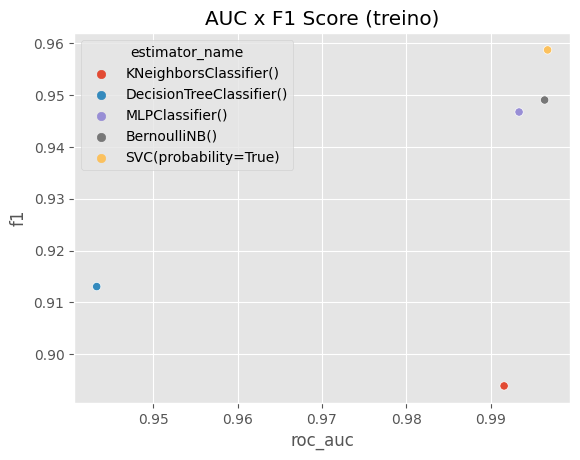

In [56]:
#potencialmente existe algum erro de cálculo nos scors do SVM
sns.scatterplot(x='mean_test_AUC', y='mean_test_F1-Score', data=train_metrics_df, hue='estimator_name')
plt.title("AUC x F1 Score (treino)")
plt.show()

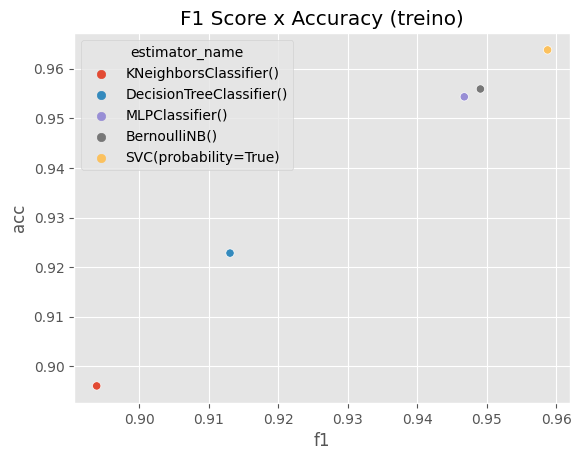

In [58]:
sns.scatterplot(x='mean_test_F1-Score', y='mean_test_Accuracy', data=train_metrics_df, hue='estimator_name')
plt.title("F1 Score x Accuracy (treino)")
plt.show()

Text(0.5, 1.0, 'Métricas (validação)')

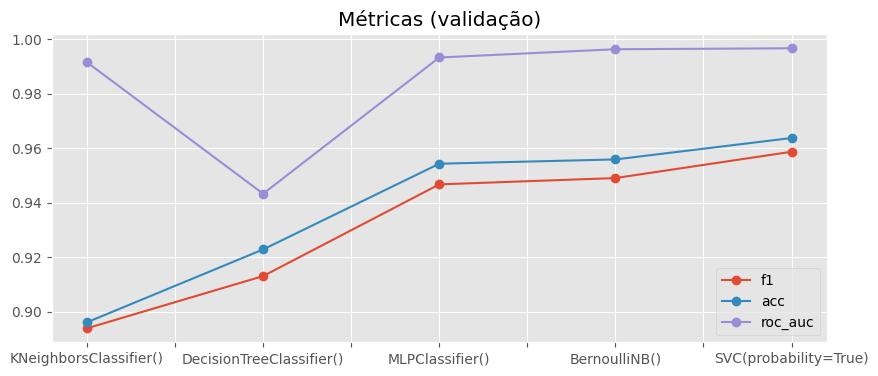

In [67]:
from matplotlib.pyplot import figure

test_metrics_df.plot(marker='o', figsize=(12,4))
plt.title("Métricas (validação)")

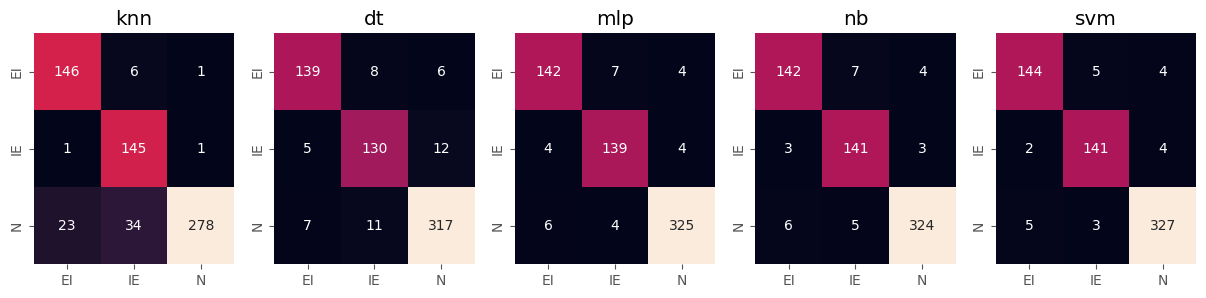

In [50]:
from sklearn.metrics import confusion_matrix

conf_mats = [confusion_matrix(y_test, b.predict(X_test)) for b in best_estimators.values()]
labels = list(estimators.keys())
classes = ct.transformers_[1][1].categories_[0].tolist()

fig, ax = plt.subplots(1,5, figsize=(15,3))

for i, cm in enumerate(conf_mats):
    sns.heatmap(cm, annot=True, fmt="", cbar=False, ax=ax[i])
    ax[i].set_xticklabels(classes)
    ax[i].set_yticklabels(classes)
    ax[i].set_title(labels[i])